In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import seaborn as sns
import statsmodels
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller, kpss, ccf

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

C:\Imperial classes\Computer\Python\envs\tensor flow\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
print(np.__version__)

1.22.3


In [3]:
eda = pd.read_csv("aihack22-electricity-main/epex_day_ahead_price.csv")
spot = pd.read_csv("aihack22-electricity-main/spot_intraday_price.csv")
systems = pd.read_csv("aihack22-electricity-main/systemprice.csv")

# 1. Data Exploration

In [4]:
eda.shape, spot.shape, systems.shape

((47858, 2), (51840, 3), (47186, 5))

In [5]:
eda.isnull().value_counts(), spot.isnull().value_counts(), systems.isnull().value_counts()

(timestamp  apx_da_hourly
 False      False            47858
 dtype: int64,
 timestamp  SP     spot_price
 False      False  False         51324
            True   True            516
 dtype: int64,
 Settlement Date  Settlement Period  System Sell Price(£/MWh)  System Buy Price(£/MWh)  Net Imbalance Volume(MWh)
 False            False              False                     False                    False                        47186
 dtype: int64)

In [6]:
eda.head()

,timestamp,apx_da_hourly
0,2019-03-31 23:00:00+00:00,26.43
1,2019-03-31 23:30:00+00:00,26.43
2,2019-04-01 00:00:00+00:00,29.24
3,2019-04-01 00:30:00+00:00,29.24
4,2019-04-01 01:00:00+00:00,35.10


In [7]:
systems.rename(columns = {"Settlement Date": "timestamp"}, inplace = True)
eda['timestamp'] = pd.to_datetime(eda['timestamp'], utc=True, infer_datetime_format=True)
spot['timestamp'] = pd.to_datetime(spot['timestamp'], utc=True, infer_datetime_format=True)
systems['timestamp'] = pd.to_datetime(systems['timestamp'], utc=True, infer_datetime_format=True)

eda_ts = eda.set_index('timestamp')
spot_ts = spot.set_index('timestamp')
systems_ts = systems.set_index('timestamp')

In [8]:
systems.head()

,timestamp,Settlement Period,System Sell Price(£/MWh),System Buy Price(£/MWh),Net Imbalance Volume(MWh)
0,2019-08-04 00:00:00+00:00,1,52.25,52.25,195.4258
1,2019-08-04 00:00:00+00:00,2,51.90,51.90,62.2486
2,2019-08-04 00:00:00+00:00,3,32.76,32.76,-40.7968
3,2019-08-04 00:00:00+00:00,4,50.85,50.85,22.6933
4,2019-08-04 00:00:00+00:00,5,51.40,51.40,186.5092


In [9]:
eda_ts["apx_da_hourly"].describe()

count    47858.000000
mean        65.311562
std         71.604595
min        -38.800000
25%         33.290000
50%         44.500000
75%         69.000000
max       1860.000000
Name: apx_da_hourly, dtype: float64

# 2. Data visulization

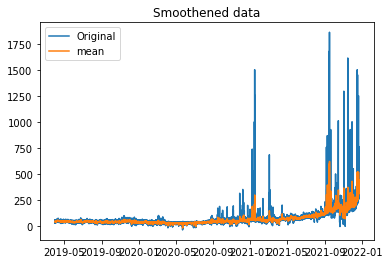

In [10]:
eda_ts['Rolling_mean'] = eda_ts['apx_da_hourly'].rolling(4*7).mean()
eda_ts['Rolling_std'] = eda_ts['apx_da_hourly'].rolling(4*7).std()
plt.plot(eda_ts.apx_da_hourly)
plt.plot(eda_ts.Rolling_mean)
plt.title("Smoothened data")
plt.legend(["Original", "mean", "std"])
plt.show()

Text(0.5, 1.0, 'Hourly change of apx_da_hourly')

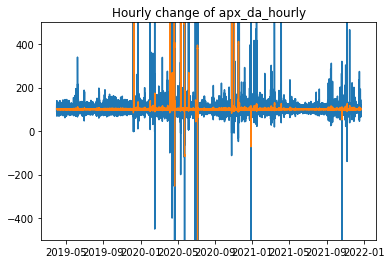

In [11]:
change = eda_ts['apx_da_hourly'].div(eda_ts['apx_da_hourly'].shift(1)).mul(100)
change_rolling = change.rolling(4*7).mean()
plt.plot(change)
plt.plot(change_rolling)
plt.ylim(-500, 500)
plt.title("Hourly change of apx_da_hourly")

Text(0.5, 1.0, 'Hourly cost frequency')

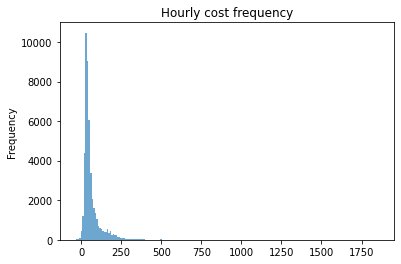

In [12]:
ax = eda_ts['apx_da_hourly'].plot.hist(bins=200, alpha=0.65)
plt.title("Hourly cost frequency")

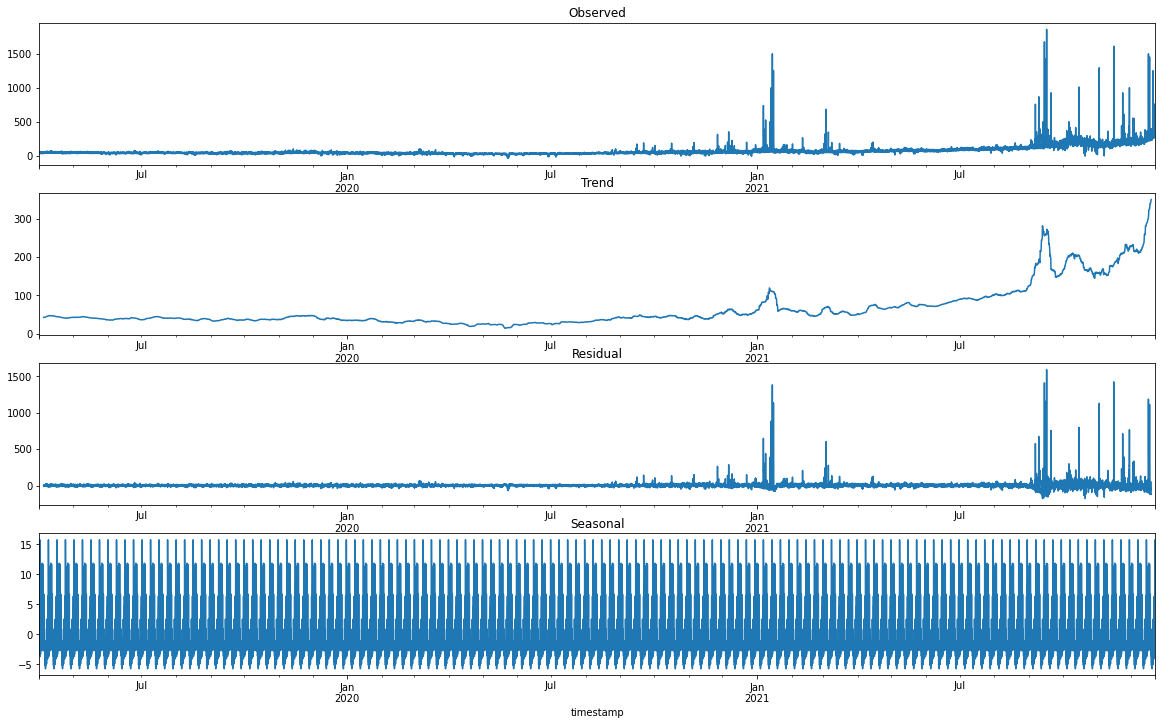

In [13]:
res = sm.tsa.seasonal_decompose(eda_ts["apx_da_hourly"], model='additive', period = 365)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.show()

In [14]:
%matplotlib inline

In [15]:
# Extreme days
extreme_days = pd.DataFrame(res.resid[res.resid.values>=500])
print(extreme_days.shape)
extreme_days.head()

(72, 1)


,resid
timestamp,
2021-01-06 17:00:00+00:00,647.182252
2021-01-06 17:30:00+00:00,639.500465
2021-01-13 17:00:00+00:00,885.276234
2021-01-13 17:30:00+00:00,883.008509
2021-01-14 16:00:00+00:00,544.624257


In [16]:
y = eda_ts["apx_da_hourly"]
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for k, v in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(k, v))

ADF Statistic: -4.760525
p-value: 0.000065
#Lags used: 56
Critical Value (1%): -3.430487
Critical Value (5%): -2.861600
Critical Value (10%): -2.566802


In [17]:
kpss_test = kpss(y, regression='c', nlags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 39.912459
p-value: 0.010000
#Lags used: 57
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


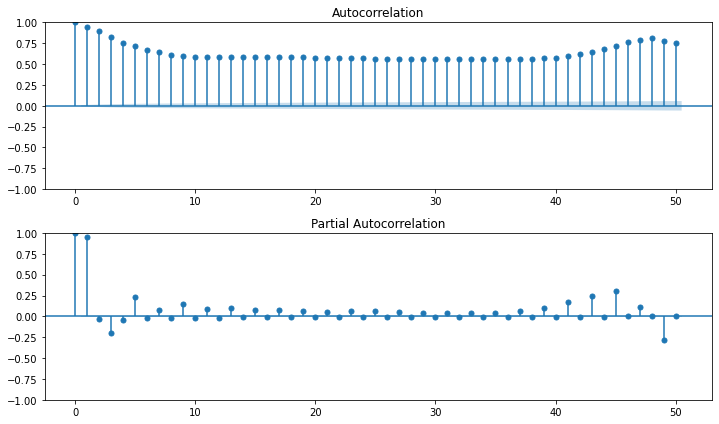

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(eda_ts["apx_da_hourly"], lags=50, ax=ax1)
plot_pacf(eda_ts["apx_da_hourly"], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

# 3. Feature engineering

In [19]:
systems_extracted = systems[systems.index<=41472]
systems_extracted["timestamp"] = eda_ts[systems_ts.index[0]:systems_ts.index[-1]].index
systems_extracted = systems_extracted.set_index("timestamp")

C:\Users\Cyrus\AppData\Local\Temp/ipykernel_8528/1912762907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  systems_extracted["timestamp"] = eda_ts[systems_ts.index[0]:systems_ts.index[-1]].index


In [20]:
spot_extracted = spot_ts[systems_ts.index[0]:systems_ts.index[-1]]
eda_extracted = eda_ts[systems_ts.index[0]:systems_ts.index[-1]]
extracted = eda_extracted.join(spot_extracted, how='outer')
extracted = extracted.join(systems_extracted, how='outer')
extracted.drop(columns = ["Rolling_mean", "Rolling_std"], inplace = True)
spot_extracted.shape, systems_extracted.shape, eda_extracted.shape, extracted.shape

((41473, 2), (41473, 4), (41473, 3), (41473, 7))

In [21]:
extracted.head()

,apx_da_hourly,SP,spot_price,Settlement Period,System Sell Price(£/MWh),System Buy Price(£/MWh),Net Imbalance Volume(MWh)
timestamp,,,,,,,
2019-08-04 00:00:00+00:00,40.00,3.0,37.30,1,52.25,52.25,195.4258
2019-08-04 00:30:00+00:00,40.00,4.0,34.33,2,51.90,51.90,62.2486
2019-08-04 01:00:00+00:00,37.14,5.0,35.97,3,32.76,32.76,-40.7968
2019-08-04 01:30:00+00:00,37.14,6.0,33.40,4,50.85,50.85,22.6933
2019-08-04 02:00:00+00:00,36.70,7.0,32.77,5,51.40,51.40,186.5092


In [22]:
features = extracted
for i in range(len(extracted)):
    position = extracted.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    features.loc[position, 'hour'] = hour
    features.loc[position, 'weekday'] = weekday
    features.loc[position, 'month'] = month
    if (weekday == 0):
        features.loc[position, 'weekday_type'] = 3
    elif (weekday == 6):
        features.loc[position, 'weekday_type'] = 2
    elif (weekday == 5):
        features.loc[position, 'weekday_type'] = 1
    else:
        features.loc[position, 'weekday_type'] = 0

In [23]:
correlations = features.corr(method='pearson')
print(correlations['apx_da_hourly'].sort_values(ascending=False).to_string())

apx_da_hourly                1.000000
spot_price                   0.719108
System Sell Price(£/MWh)     0.262259
System Buy Price(£/MWh)      0.262259
month                        0.226790
SP                           0.124810
hour                         0.109591
Settlement Period            0.103588
Net Imbalance Volume(MWh)    0.079482
weekday_type                -0.025539
weekday                     -0.049272


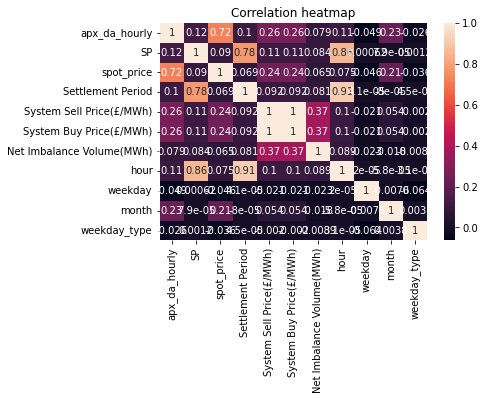

In [24]:
sns.heatmap(correlations, annot = True)
plt.title("Correlation heatmap")
plt.show()

In [25]:
X = features.drop(columns = "apx_da_hourly")
y = features["apx_da_hourly"]

In [26]:
end = round(0.95*len(extracted))

In [27]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaler_X.fit(X[:end])
scaler_y.fit(y[:end].values.reshape(-1,1))

X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y.values.reshape(-1,1))

In [28]:
X_norm[:end].shape, y_norm[:end].shape

((39399, 10), (39399, 1))

In [29]:
Xy = pd.DataFrame(X_norm)
Xy[10] = y_norm
Xy.dropna(inplace = True)

In [30]:
Xy

,0,1,2,3,4,5,6,7,8,9,10
0,0.042553,0.045153,0.000000,0.034308,0.034308,0.578580,0.000000,1.000000,0.636364,0.666667,0.041500
1,0.063830,0.044187,0.020408,0.034222,0.034222,0.547496,0.000000,1.000000,0.636364,0.666667,0.041500
2,0.085106,0.044720,0.040816,0.029540,0.029540,0.523445,0.043478,1.000000,0.636364,0.666667,0.039994
3,0.106383,0.043885,0.061224,0.033965,0.033965,0.538264,0.043478,1.000000,0.636364,0.666667,0.039994
4,0.127660,0.043680,0.081633,0.034100,0.034100,0.576499,0.086957,1.000000,0.636364,0.666667,0.039762
...,...,...,...,...,...,...,...,...,...,...,...
41468,0.936170,0.080103,0.897959,0.053082,0.053082,0.538724,0.956522,0.166667,1.000000,0.000000,0.136297
41469,0.957447,0.080574,0.918367,0.053804,0.053804,0.569843,0.956522,0.166667,1.000000,0.000000,0.136297
41470,0.978723,0.058836,0.938776,0.053694,0.053694,0.580285,1.000000,0.166667,1.000000,0.000000,0.144196
41471,1.000000,0.087598,0.959184,0.038305,0.038305,0.516546,1.000000,0.166667,1.000000,0.000000,0.144196


In [31]:
X_norm2 = Xy.drop(columns = 10)
y_norm2 = Xy[10]
X_norm2.shape, y_norm2.shape

((41102, 10), (41102,))

In [32]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [33]:
pca = PCA()
X_pca = pca.fit(X_norm2[:end])
pca = PCA(n_components=0.80)
pca.fit(X_norm2[:end])
X_pca = pca.transform(X_norm2)

In [34]:
y_norm2 = np.array(y_norm2).reshape(len(y_norm2),1)
dataset_norm = np.concatenate((X_pca, y_norm2), axis=1)

past_history = 4
future_target = 0
end_all = len(y_norm2)

In [35]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, end, past_history, 
                                     future_target, step=1, single_step=True)

In [36]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 end, end_all, past_history, 
                                 future_target, step=1, single_step=True)

In [37]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   end, end_all, past_history, 
                                   future_target, step=1, single_step=True)

In [38]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

In [39]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

# 4. XGBoost forecasting

In [40]:
param = {'eta': 0.03, 'max_depth': 180, 
         'subsample': 1.0, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=3)

[10:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[10:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.43552	eval-rmse:0.36184
[1]	train-rmse:0.42246	eval-rmse:0.35100
[2]	train-rmse:0.40980	eval-rmse:0.34054
[3]	train-rmse:0.39751	eval-rmse:0.33030
[4]	train-rmse:0.38560	eval-rmse:0.32047
[5]	train-rmse:0.37404	eval-rmse:0.31089
[6]	train-rmse:0.36282	eval-rmse:0.30159
[7]	train-rmse:0.35195	eval-rmse:0.29259
[8]	train-rmse:0.34140	eval-rmse:0.28385
[9]	train-rmse:0.33116	eval-rmse:0.2753

In [41]:
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

rmse_xgb = np.sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE of hour-ahead electricity price XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))

RMSE of hour-ahead electricity price XGBoost forecast: 47.762


# 5. Results

<IPython.core.display.Javascript object>


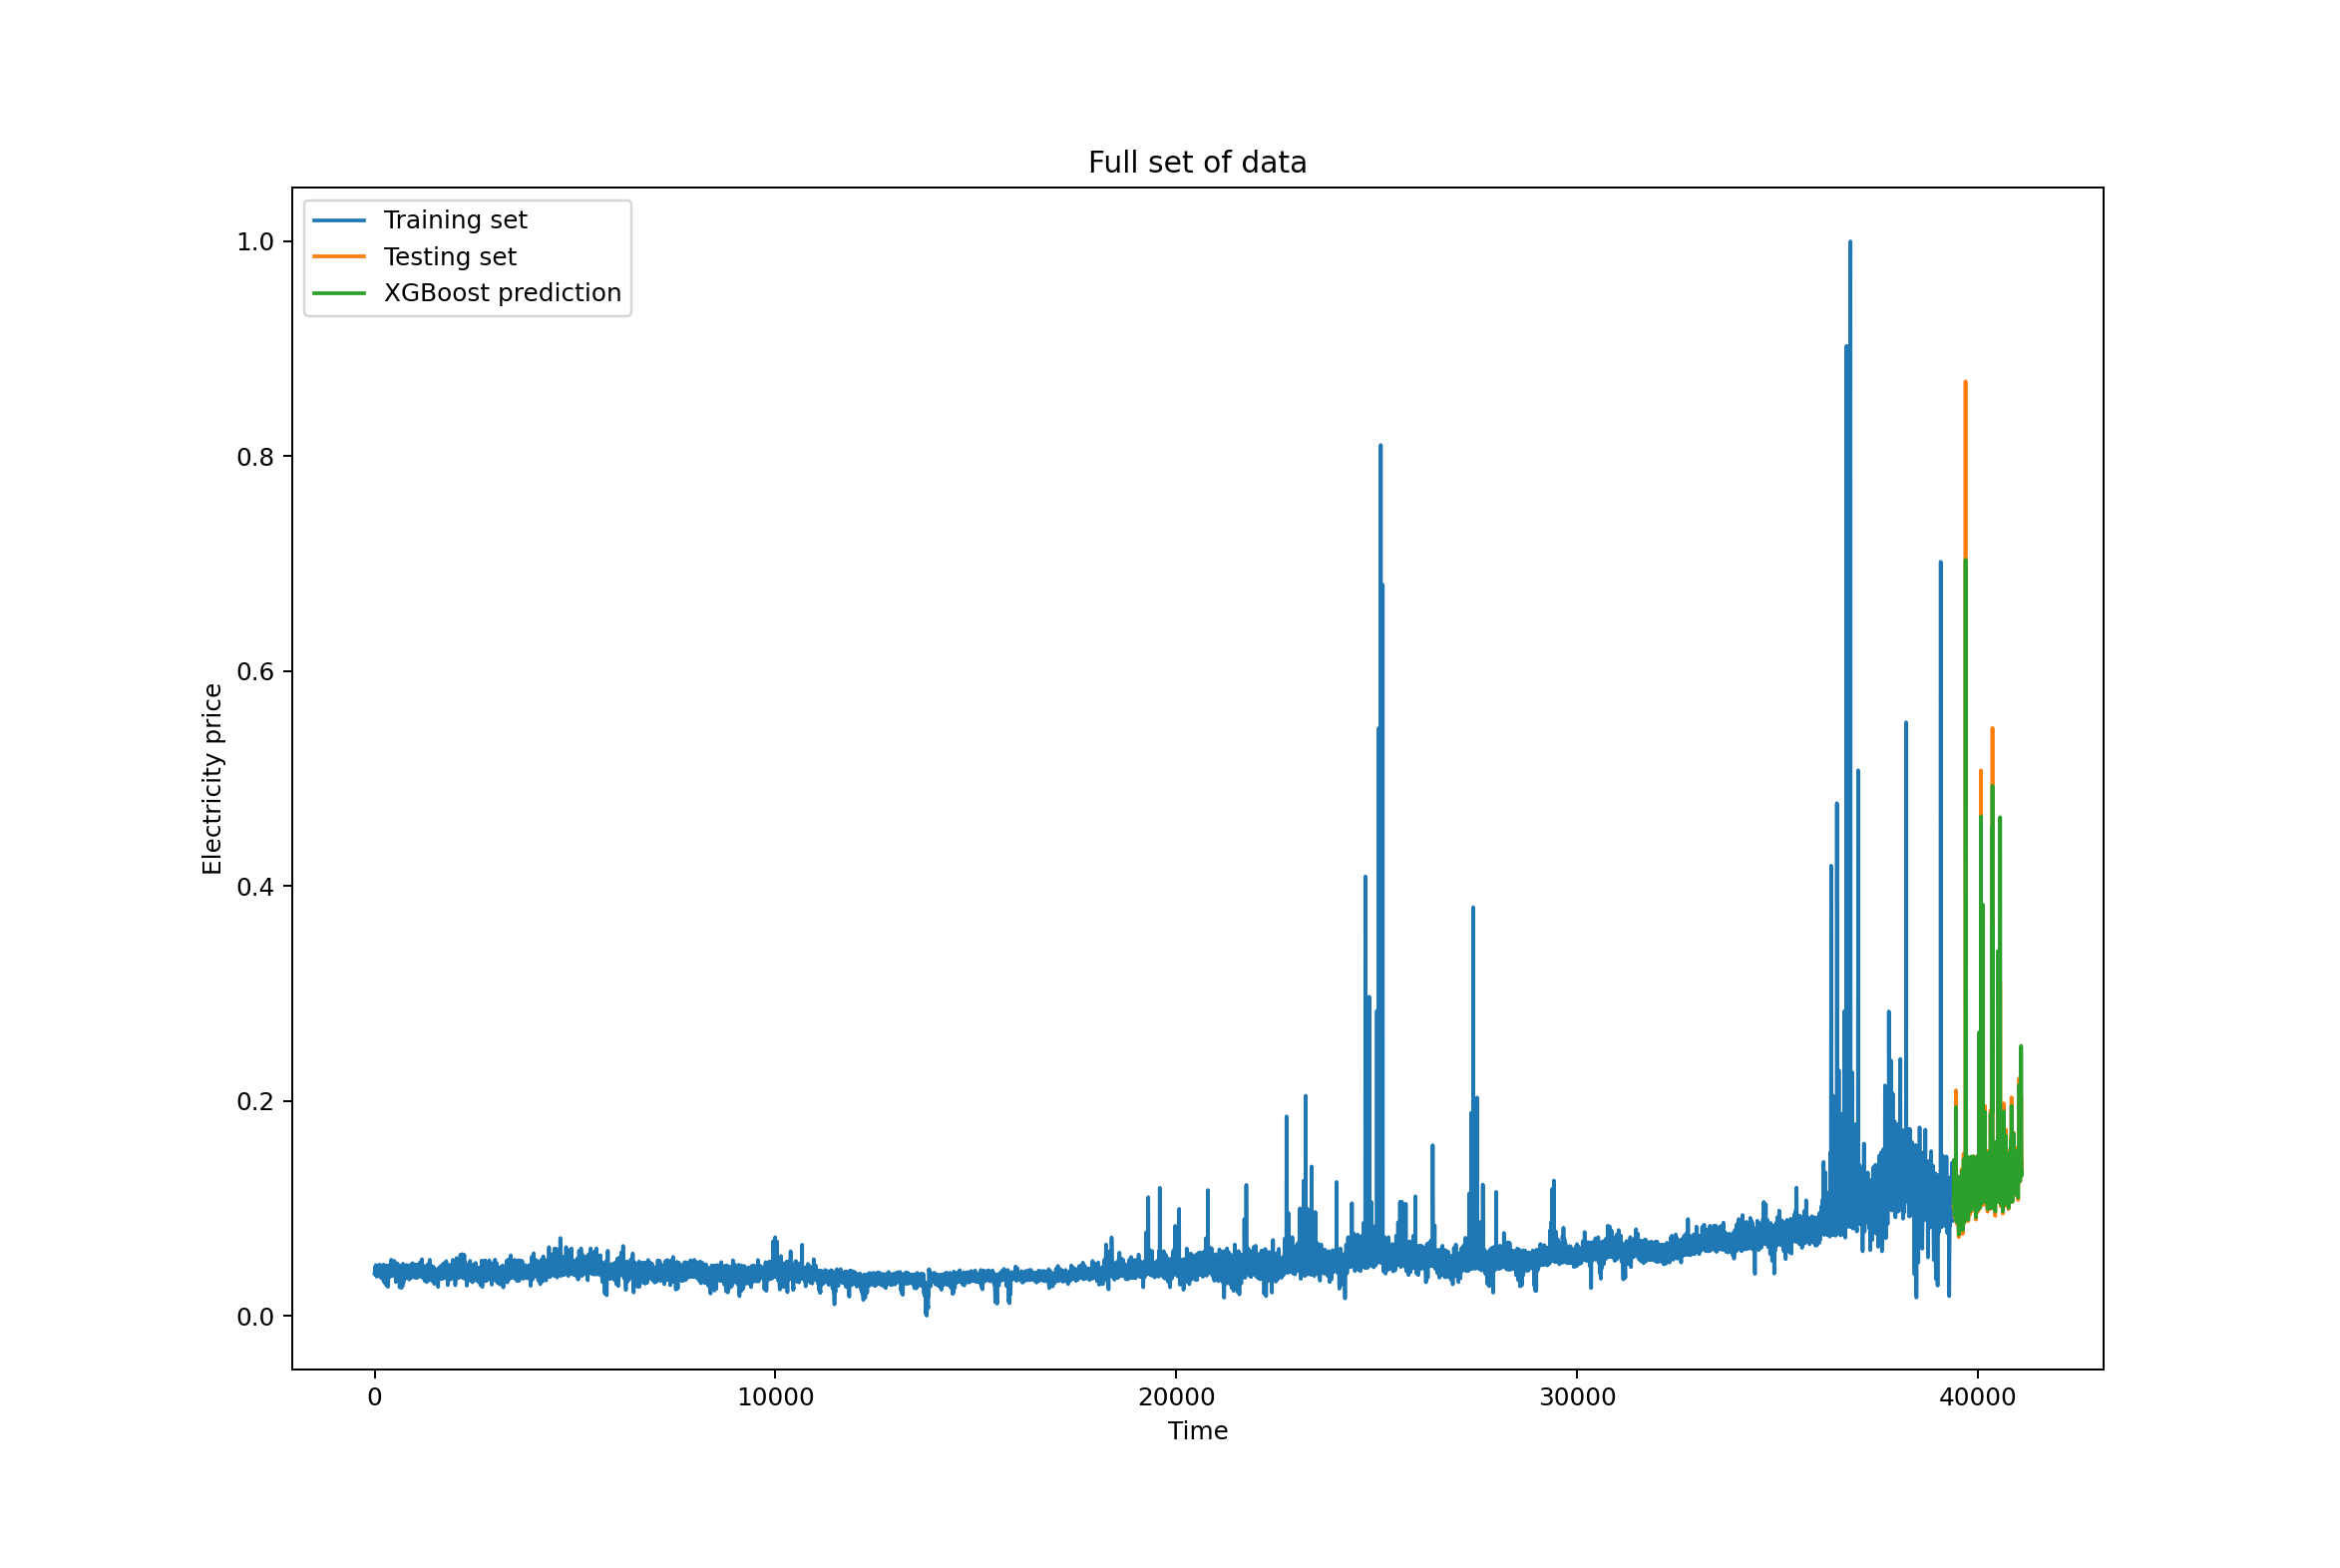

In [52]:
%matplotlib notebook
s = len(y_train)
e = len(y_train)+len(y_test)
plt.plot(np.arange(s), y_train)
plt.plot(np.arange(s, e), y_test)
plt.plot(np.arange(s, e), xgb_forecast)
plt.title("Full set of data")
plt.ylabel("Electricity price")
plt.xlabel("Time")
plt.legend(["Training set", "Testing set", "XGBoost prediction"])
plt.show()

In [50]:
datetime.datetime.fromtimestamp(s)

datetime.datetime(1970, 1, 1, 10, 56, 35)

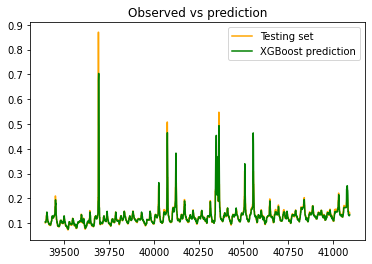

In [43]:
plt.plot(np.arange(s, e), y_test, color = "orange")
plt.plot(np.arange(s, e), xgb_forecast, color = "green")
plt.title("Observed vs prediction")
plt.legend(["Testing set", "XGBoost prediction"])
plt.show()

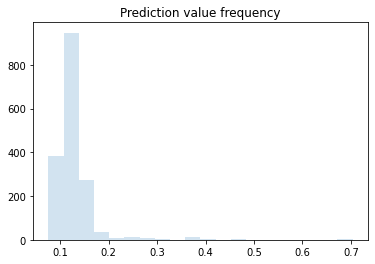

In [44]:
plt.hist(forecast, bins = 20, alpha = 0.2)
plt.title("Prediction value frequency")
plt.show()